The FinBERT pretrained model can be fine-tuned on downstream financial NLP tasks. This notebook illustrates the process of fine-tuning FinBERT using Huggingface 🤗's tranformers library. You can modify this notebook accordingly to meet you needs.

In [1]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import torch
import transformers
torch.__version__, transformers.__version__

('2.5.1+cu121', '4.57.1')

*Note: the following code is for demonstration purpose. Please use GPU for fast inference on large scale dataset.*

In [3]:
torch.cuda.is_available()

True

### load dataset

In [4]:
from datasets import load_dataset
ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_val.head()

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


In [5]:
df_train = df_train.dropna(subset=["text", "label"]) ## drop missing values
df_val = df_val.dropna(subset=["text", "label"]) ## drop missing values

### load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = r"D:\huggingface_cache\finbert_tone\models--yiyanghkust--finbert-tone\snapshots\4921590d3c0c3832c0efea24c8381ce0bda7844b"
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    num_labels=3,
    use_safetensors=True
)

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

### prepare dataset for fine-tuning

In [ ]:
from datasets import Dataset

# 1. Convert to HF Dataset

dataset_train = Dataset.from_pandas(df_train)
# using 20% dataset
dataset_train = dataset_train.select(range(int(0.2 * len(dataset_train))))
# # using 40% dataset
# dataset_train = dataset_train.select(range(int(0.4 * len(dataset_train))))
# # using 60% dataset
# dataset_train = dataset_train.select(range(int(0.6 * len(dataset_train))))
# # using 80% dataset
# dataset_train = dataset_train.select(range(int(0.8 * len(dataset_train))))

dataset_val = Dataset.from_pandas(df_val)

# 2. tokenize
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

dataset_train = dataset_train.map(tokenize_fn, batched=True)
dataset_val = dataset_val.map(tokenize_fn, batched=True)

# 3. rename label → labels (Trainer requirement)
dataset_train = dataset_train.rename_column("label", "labels")
dataset_val = dataset_val.rename_column("label", "labels")


# 4. Set torch format
dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dataset_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(dataset_train)
print(dataset_val)



Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1908
})
Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2388
})


### define training options

In [12]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)


# define parameters
args = TrainingArguments(
    output_dir="D:/huggingface_cache/finbert_tone_finetuned/",
    
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    logging_strategy="epoch",
)


# build Trainer
trainer = Trainer(
    model=model,                 
    args=args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.058000,1.059913,0.824121
2,0.033100,1.031406,0.836265
3,0.015300,1.201489,0.814070
4,0.005200,1.186255,0.824958
5,0.001700,1.196394,0.826633


TrainOutput(global_step=300, training_loss=0.02264555255572001, metrics={'train_runtime': 179.1509, 'train_samples_per_second': 53.251, 'train_steps_per_second': 1.675, 'total_flos': 627525501281280.0, 'train_loss': 0.02264555255572001, 'epoch': 5.0})

### evaluate on testing set

Percent of data used VS accuracy

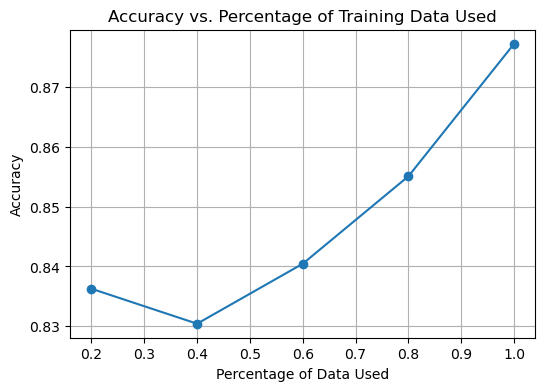

In [13]:
import matplotlib.pyplot as plt

mydict = {0.2:0.836265, 0.4:0.830402, 0.6:0.840452, 0.8:0.855109, 1:0.877303}
xs = list(sorted(mydict.keys()))
ys = [mydict[x] for x in xs]

plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker='o')
plt.title("Accuracy vs. Percentage of Training Data Used")
plt.xlabel("Percentage of Data Used")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

### save the fine-tuned model

In [ ]:
trainer.save_model("D:/huggingface_cache/finbert_sentiment_Henry/")
tokenizer.save_pretrained("D:/huggingface_cache/finbert_sentiment_Henry/")

('D:/huggingface_cache/finbert_sentiment_Henry/tokenizer_config.json',
 'D:/huggingface_cache/finbert_sentiment_Henry/special_tokens_map.json',
 'D:/huggingface_cache/finbert_sentiment_Henry/vocab.txt',
 'D:/huggingface_cache/finbert_sentiment_Henry/added_tokens.json',
 'D:/huggingface_cache/finbert_sentiment_Henry/tokenizer.json')

### Compare the original model and my model on another dataset

In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Comparison over this validation set

In [39]:
def evaluate_1(model_path, name, remap=False):
    
    print(f"\n===== Evaluating {name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    test_dataset = Dataset.from_pandas(df_val)

    # Tokenization
    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    test_dataset = test_dataset.map(tokenize_fn, batched=True)

    # convert to torch
    test_dataset = test_dataset.rename_column("label", "labels")
    test_dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]
    )

    all_preds = []
    all_labels = []

    for batch in test_dataset:
        input_ids = batch["input_ids"].unsqueeze(0)
        attention_mask = batch["attention_mask"].unsqueeze(0)

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            pred = logits.argmax(dim=-1).item()

        true_label = batch["labels"].item()

        if remap==True:
            remap_dict = {0: 2, 1: 1, 2: 0}
            pred = remap_dict[pred]

        all_preds.append(pred)
        all_labels.append(true_label)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    return {
        "model": name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
results = []

results.append(
    evaluate_1(
        model_path="D:/huggingface_cache/finbert_sentiment_Henry/",
        name="FinBERT-Henry (fine-tuned)",
        remap=False
    )
)

results.append(
    evaluate_1(
        model_path=r"D:\huggingface_cache\finbert_tone\models--yiyanghkust--finbert-tone",
        name="FinBERT Original",
        remap=True
    )
)

res_df = pd.DataFrame(results)
print(res_df)



===== Evaluating FinBERT-Henry (fine-tuned) =====


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]


===== Evaluating FinBERT Original =====


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

                        model  accuracy  precision    recall        f1
0  FinBERT-Henry (fine-tuned)  0.877303   0.879035  0.877303  0.877833
1            FinBERT Original  0.748325   0.740712  0.748325  0.742370


Comparison over the new dataset

In [2]:
test_path = r"C:\Users\24167\Desktop\STATS507\HW\project\Sentences_AllAgree.txt"
sentences = []
labels = []

with open(test_path, "r", encoding="latin-1") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        # split by @
        parts = line.rsplit("@", 1)
        sentence = parts[0].strip()
        label = parts[1].strip()

        sentences.append(sentence)
        labels.append(label)

df = pd.DataFrame({"sentence": sentences, "label": labels})
print(df.head())

                                            sentence     label
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive


In [ ]:
def evaluate_2(model_path, name, remap=False):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    label_map = {"negative": 0, "neutral": 2, "positive": 1}

    true_labels = df["label"].str.lower().map(label_map)

    if true_labels.isna().any():
        raise ValueError(
            f"Found unknown labels: {df['label'][true_labels.isna()].unique()}"
        )

    preds = []
    for text in df["sentence"]:
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
        # This is for the original model because the original model's label is not the same with mine
        if remap == True:
            pred = {0: 2, 1: 1, 2: 0}[pred]
        preds.append(pred)

    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, preds, average="macro"
    )

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

results = []

In [ ]:
# My fine-tune model
results.append(
    evaluate_2("D:/huggingface_cache/finbert_sentiment_Henry/", 
             "FinBERT-Henry (fine-tuned)",
             remap=False)
)

# Original model FinBERT-tone
results.append(
    evaluate_2(r"D:\huggingface_cache\finbert_tone\models--yiyanghkust--finbert-tone", 
             "FinBERT Original",
             remap=True)
)

res_df = pd.DataFrame(results)
print("\n\n===== Comparison =====")
print(res_df)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.




===== Comparison =====
                        Model  Accuracy  Precision    Recall        F1
0  FinBERT-Henry (fine-tuned)  0.893551   0.898623  0.840051  0.864281
1            FinBERT Original  0.916961   0.918892  0.885625  0.897073
